# Sparkify Project Workspace
This project will serve as an exploration of how to make a churn-prediction model using Spark.

We will use the Sparkify dataset. Sparkify is a music streaming service just as Spotify and Pandora.<br>
The data provided is the user log of the service, having demographic info, user activities, timestamps and etc.<br>
This workspace contains a tiny subset (128MB) of the full dataset available (12GB).

We will analyze the log and build a model to identify customers who are highly likely to quit using our service, and thus, send marketing offers to them to prevent them from churning with the following steps included:
- Data Explorations and Manipulation
- Feature Engineering
- Split data into train and test sets in order to be able to measure the accuracy of the ML model we'll apply on the data
- Build several ML classifier models with Spark's DataFrame-based MLlib
- Select the best ML model and fine-tune its parameters to come up with the final model, using Spark's ML Pipelines and Cross Validation

In [2]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql import Window

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml import feature as FT
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import Evaluator, BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import StandardScaler, VectorAssembler

import time
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# create a Spark session
spark = SparkSession.builder.getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## Load Data

In [4]:
user_log = spark.read.json('mini_sparkify_event_data.json')

In [5]:
user_log.count()

286500

In [6]:
user_log.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [7]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



## Clean Data
 - Check for missing/Null/Empty Values
 - Delete NAs
 - Remove rows with empty as `UserId`
 - Convert `gender` column to binary numeric column
 - Convert `ts` and `registration` columns to human readable time stamp format.

In [8]:
# check: NaN values per column
count_nan_cols = [F.count(F.when(F.isnan(c), c)).alias(c) for c in user_log.columns]
user_log.select(count_nan_cols).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


There are no NaN values in any column.

In [9]:
# check: null values per column
count_null_cols = [F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in user_log.columns]
user_log.select(count_null_cols).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,58392,0,8346,8346,0,8346,58392,0,8346,0,0,8346,0,58392,0,0,8346,0


Null values are found in columns related with user information and song information.

In [10]:
user_log.filter(F.col('artist').isNull()).toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged In,Colin,M,54,Freeman,None,paid,"Bakersfield, CA",PUT,Add to Playlist,1.538173e+12,29,None,200,1538352905000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,None,Logged In,Micah,M,84,Long,None,free,"Boston-Cambridge-Newton, MA-NH",GET,Roll Advert,1.538332e+12,8,None,200,1538353150000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,None,Logged In,Micah,M,86,Long,None,free,"Boston-Cambridge-Newton, MA-NH",PUT,Thumbs Up,1.538332e+12,8,None,307,1538353376000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
3,None,Logged In,Alexi,F,4,Warren,None,paid,"Spokane-Spokane Valley, WA",GET,Downgrade,1.532483e+12,53,None,200,1538354749000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54
4,None,Logged In,Alexi,F,7,Warren,None,paid,"Spokane-Spokane Valley, WA",PUT,Thumbs Up,1.532483e+12,53,None,307,1538355255000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,54


Pages that are not `NextSong` will have null values for `artist`, `length` and `song`. 

In [11]:
user_log.filter(F.col('artist').isNull()).select('page').dropDuplicates().sort('page').show(30, False)

+-------------------------+
|page                     |
+-------------------------+
|About                    |
|Add Friend               |
|Add to Playlist          |
|Cancel                   |
|Cancellation Confirmation|
|Downgrade                |
|Error                    |
|Help                     |
|Home                     |
|Login                    |
|Logout                   |
|Register                 |
|Roll Advert              |
|Save Settings            |
|Settings                 |
|Submit Downgrade         |
|Submit Registration      |
|Submit Upgrade           |
|Thumbs Down              |
|Thumbs Up                |
|Upgrade                  |
+-------------------------+



In [12]:
user_log.filter(F.col('artist').isNull()!=True).toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [13]:
user_log.filter(F.col('artist').isNull()!=True).select('page').dropDuplicates().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



In [14]:
# check: empty values per column
count_invalid_cols = [F.count(F.when(F.col(c)=='', c)).alias(c) for c in user_log.columns]
user_log.select(count_invalid_cols).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8346


Users with empty `userId` are those who did not register and log in.

In [15]:
user_log.filter(F.col('userId')=='').toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,None,Logged Out,None,None,100,None,None,free,None,GET,Home,None,8,None,200,1538355745000,None,
1,None,Logged Out,None,None,101,None,None,free,None,GET,Help,None,8,None,200,1538355807000,None,
2,None,Logged Out,None,None,102,None,None,free,None,GET,Home,None,8,None,200,1538355841000,None,
3,None,Logged Out,None,None,103,None,None,free,None,PUT,Login,None,8,None,307,1538355842000,None,
4,None,Logged Out,None,None,2,None,None,free,None,GET,Home,None,240,None,200,1538356678000,None,


In [16]:
user_log.filter(F.col('userId')=='').groupBy('registration', 'auth').count().toPandas()

,registration,auth,count
0,None,Logged Out,8249
1,None,Guest,97


#### Drop rows with empty userId
Since logs with empty `userId` can’t help us identify the users behind, we can’t make predictions for them. So we will drop all those rows from our analysis' dataset.

In [17]:
df = user_log.filter(F.col('userId')!='')
df.count()

278154

In [18]:
droped_cases = user_log.count() - df.count()

In [19]:
print("There were {} cases in our dataset with empty userId and droped.".format(droped_cases))

There were 8346 cases in our dataset with empty userId and droped.


In [107]:
8346/286500

0.029130890052356022

#### Convert Timestamps (ms) to Datetime

In [20]:
df = df.withColumn('reg_dt', (F.col('registration')/1000).cast(T.TimestampType()))
df = df.withColumn('dt', (F.col('ts')/1000).cast(T.TimestampType()))

# Exploratory Data Analysis
## Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

#### Create churn column

In [21]:
flag_churn = F.udf(lambda x: 1 if x == 'Cancellation Confirmation' else 0, T.IntegerType())
df = df.withColumn('churn', flag_churn('page'))

## Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

### Transform Data

#### User-based Observation Start/End Date

In [22]:
min_dt = df.agg({'dt':'min'}).collect()[0]['min(dt)']
max_dt = df.agg({'dt':'max'}).collect()[0]['max(dt)']
min_reg_dt = df.agg({'reg_dt':'min'}).collect()[0]['min(reg_dt)']
max_reg_dt = df.agg({'reg_dt':'max'}).collect()[0]['max(reg_dt)']
print(f'min_dt:{min_dt}')
print(f'max_dt:{max_dt}')
print(f'min_reg_dt:{min_reg_dt}')
print(f'max_reg_dt:{max_reg_dt}')

min_dt:2018-10-01 00:01:57
max_dt:2018-12-03 01:11:16
min_reg_dt:2018-03-18 13:44:35
max_reg_dt:2018-11-26 15:49:14


In [23]:
# get first log date
w = Window.partitionBy('userId').orderBy('ts').rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
df = df.withColumn('first_dt', F.first('dt').over(w))

In [24]:
# infer observation start date
# - for users with reg_dt < min_dt, use min_dt for obs_start
# - for users with min_dt <= reg_dt < first_dt, use reg_dt for obs_start
# - for users with reg_dt >= first_dt, use first_dt for obs_start
df = df.withColumn('obs_start', 
                   (F.when(F.col('reg_dt')<min_dt, min_dt)
                     .when(F.col('reg_dt')<F.col('first_dt'), F.col('reg_dt'))
                     .otherwise(F.col('first_dt')))
                  )

In [25]:
# infer observation end date
# - for churn users, use churn date for obs_end
# - for non-churn users, use max_dt for obs_end
df = df.withColumn('obs_end', 
                   (F.when(F.last('churn').over(w)==1, F.last('dt').over(w))
                     .otherwise(max_dt))
                  )

In [26]:
# a function to check date-related columns for a user
def display_user(user_id):
    return (df.where(F.col('userId')==user_id)
              .select('userId', 'page', 'reg_dt', 'dt', 'obs_start', 'obs_end')
              .sort('dt')
              .toPandas())

In [27]:
# check: users registered before min_dt
df.filter(F.col('reg_dt')<=min_dt).groupBy('userId').agg({'churn':'max'}).show()

+------+----------+
|userId|max(churn)|
+------+----------+
|100010|         0|
|200002|         0|
|   125|         1|
|    51|         1|
|   124|         0|
|     7|         0|
|    54|         1|
|    15|         0|
|   132|         0|
|100014|         1|
|   101|         1|
|    11|         0|
|   138|         0|
|300017|         0|
|    29|         1|
|    69|         0|
|100021|         1|
|    42|         0|
|   112|         0|
|    87|         1|
+------+----------+
only showing top 20 rows



In [28]:
# a non-churn user
display_user('100010')

,userId,page,reg_dt,dt,obs_start,obs_end
0,100010,NextSong,2018-09-27 02:45:40,2018-10-08 12:58:54,2018-10-01 00:01:57,2018-12-03 01:11:16
1,100010,NextSong,2018-09-27 02:45:40,2018-10-08 13:02:16,2018-10-01 00:01:57,2018-12-03 01:11:16
2,100010,NextSong,2018-09-27 02:45:40,2018-10-08 13:05:32,2018-10-01 00:01:57,2018-12-03 01:11:16
3,100010,Thumbs Up,2018-09-27 02:45:40,2018-10-08 13:05:33,2018-10-01 00:01:57,2018-12-03 01:11:16
4,100010,NextSong,2018-09-27 02:45:40,2018-10-08 13:09:55,2018-10-01 00:01:57,2018-12-03 01:11:16
5,100010,NextSong,2018-09-27 02:45:40,2018-10-08 13:15:11,2018-10-01 00:01:57,2018-12-03 01:11:16
6,100010,NextSong,2018-09-27 02:45:40,2018-10-08 13:18:14,2018-10-01 00:01:57,2018-12-03 01:11:16
7,100010,NextSong,2018-09-27 02:45:40,2018-10-08 13:21:58,2018-10-01 00:01:57,2018-12-03 01:11:16
8,100010,Roll Advert,2018-09-27 02:45:40,2018-10-08 13:22:41,2018-10-01 00:01:57,2018-12-03 01:11:16
9,100010,NextSong,2018-09-27 02:45:40,2018-10-08 13:25:57,2018-10-01 00:01:57,2018-12-03 01:11:16


In [29]:
# a churned user
display_user('125')

,userId,page,reg_dt,dt,obs_start,obs_end
0,125,NextSong,2018-08-01 20:58:59,2018-10-12 04:05:44,2018-10-01 00:01:57,2018-10-12 04:35:18
1,125,NextSong,2018-08-01 20:58:59,2018-10-12 04:11:21,2018-10-01 00:01:57,2018-10-12 04:35:18
2,125,NextSong,2018-08-01 20:58:59,2018-10-12 04:15:11,2018-10-01 00:01:57,2018-10-12 04:35:18
3,125,NextSong,2018-08-01 20:58:59,2018-10-12 04:18:34,2018-10-01 00:01:57,2018-10-12 04:35:18
4,125,NextSong,2018-08-01 20:58:59,2018-10-12 04:22:04,2018-10-01 00:01:57,2018-10-12 04:35:18
5,125,NextSong,2018-08-01 20:58:59,2018-10-12 04:28:35,2018-10-01 00:01:57,2018-10-12 04:35:18
6,125,NextSong,2018-08-01 20:58:59,2018-10-12 04:32:08,2018-10-01 00:01:57,2018-10-12 04:35:18
7,125,NextSong,2018-08-01 20:58:59,2018-10-12 04:35:06,2018-10-01 00:01:57,2018-10-12 04:35:18
8,125,Roll Advert,2018-08-01 20:58:59,2018-10-12 04:35:17,2018-10-01 00:01:57,2018-10-12 04:35:18
9,125,Cancel,2018-08-01 20:58:59,2018-10-12 04:35:18,2018-10-01 00:01:57,2018-10-12 04:35:18


In [30]:
# check: users registered after min_dt
df.filter(F.col('reg_dt')>min_dt).groupBy('userId').agg({'churn':'max'}).show()

+------+----------+
|userId|max(churn)|
+------+----------+
|   155|         0|
|   154|         0|
|   156|         0|
|   153|         0|
|   152|         0|
+------+----------+



In [31]:
# normal case: registration date is before the first log date
# use registration date for obs_start
display_user('156')

,userId,page,reg_dt,dt,obs_start,obs_end
0,156,Home,2018-11-26 15:49:14,2018-11-26 23:14:00,2018-11-26 15:49:14,2018-12-03 01:11:16
1,156,NextSong,2018-11-26 15:49:14,2018-11-26 23:14:02,2018-11-26 15:49:14,2018-12-03 01:11:16
2,156,Roll Advert,2018-11-26 15:49:14,2018-11-26 23:15:10,2018-11-26 15:49:14,2018-12-03 01:11:16
3,156,NextSong,2018-11-26 15:49:14,2018-11-26 23:17:43,2018-11-26 15:49:14,2018-12-03 01:11:16
4,156,Settings,2018-11-26 15:49:14,2018-11-26 23:18:35,2018-11-26 15:49:14,2018-12-03 01:11:16
5,156,NextSong,2018-11-26 15:49:14,2018-11-26 23:21:00,2018-11-26 15:49:14,2018-12-03 01:11:16


In [32]:
# weird case: registration date is after the first log date
# use the first log date for obs_start
display_user('154')

,userId,page,reg_dt,dt,obs_start,obs_end
0,154,Home,2018-11-03 18:00:21,2018-11-02 15:15:35,2018-11-02 15:15:35,2018-12-03 01:11:16
1,154,NextSong,2018-11-03 18:00:21,2018-11-02 15:15:38,2018-11-02 15:15:35,2018-12-03 01:11:16
2,154,NextSong,2018-11-03 18:00:21,2018-11-02 15:18:39,2018-11-02 15:15:35,2018-12-03 01:11:16
3,154,NextSong,2018-11-03 18:00:21,2018-11-02 15:22:19,2018-11-02 15:15:35,2018-12-03 01:11:16
4,154,NextSong,2018-11-03 18:00:21,2018-11-02 15:26:59,2018-11-02 15:15:35,2018-12-03 01:11:16
5,154,NextSong,2018-11-03 18:00:21,2018-11-02 15:32:26,2018-11-02 15:15:35,2018-12-03 01:11:16
6,154,Roll Advert,2018-11-03 18:00:21,2018-11-02 15:33:03,2018-11-02 15:15:35,2018-12-03 01:11:16
7,154,NextSong,2018-11-03 18:00:21,2018-11-02 15:36:29,2018-11-02 15:15:35,2018-12-03 01:11:16
8,154,NextSong,2018-11-03 18:00:21,2018-11-02 15:40:35,2018-11-02 15:15:35,2018-12-03 01:11:16
9,154,Add to Playlist,2018-11-03 18:00:21,2018-11-02 15:40:46,2018-11-02 15:15:35,2018-12-03 01:11:16


#### Last Subscription Level

In [33]:
# last subscription level
df = df.withColumn('last_level', F.last('level').over(w))

#### Aggregation by User

In [34]:
user_df = df.groupby('userId').agg(
    # User-level features
    F.max('churn').alias('churn'),
    F.first('gender').alias('gender'),
    F.first('reg_dt').alias('reg_dt'),
    F.first('obs_start').alias('obs_start'),
    F.first('obs_end').alias('obs_end'),
    F.first('last_level').alias('last_level'),

    # interaction-level features (exclude Cancellation Confirmation)
    F.count('page').alias('n_act'),
    F.sum(F.when(F.col('page')=='About', 1).otherwise(0)).alias('n_about'),
    F.sum(F.when(F.col('page')=='Add Friend', 1).otherwise(0)).alias('n_addFriend'),
    F.sum(F.when(F.col('page')=='Add to Playlist', 1).otherwise(0)).alias('n_addToPlaylist'),
    F.sum(F.when(F.col('page')=='Cancel', 1).otherwise(0)).alias('n_cancel'),
    F.sum(F.when(F.col('page')=='Downgrade', 1).otherwise(0)).alias('n_downgrade'),
    F.sum(F.when(F.col('page')=='Error', 1).otherwise(0)).alias('n_error'),
    F.sum(F.when(F.col('page')=='Help', 1).otherwise(0)).alias('n_help'),
    F.sum(F.when(F.col('page')=='Home', 1).otherwise(0)).alias('n_home'),
    F.sum(F.when(F.col('page')=='Logout', 1).otherwise(0)).alias('n_logout'),
    F.sum(F.when(F.col('page')=='NextSong', 1).otherwise(0)).alias('n_song'),
    F.sum(F.when(F.col('page')=='Roll Advert', 1).otherwise(0)).alias('n_rollAdvert'),
    F.sum(F.when(F.col('page')=='Save Settings', 1).otherwise(0)).alias('n_saveSettings'),
    F.sum(F.when(F.col('page')=='Settings', 1).otherwise(0)).alias('n_settings'),
    F.sum(F.when(F.col('page')=='Submit Downgrade', 1).otherwise(0)).alias('n_submitDowngrade'),
    F.sum(F.when(F.col('page')=='Submit Upgrade', 1).otherwise(0)).alias('n_submitUpgrade'),
    F.sum(F.when(F.col('page')=='Thumbs Down', 1).otherwise(0)).alias('n_thumbsDown'),
    F.sum(F.when(F.col('page')=='Thumbs Up', 1).otherwise(0)).alias('n_thumbsUp'),
    F.sum(F.when(F.col('page')=='Upgrade', 1).otherwise(0)).alias('n_upgrade'),

    # song-level features
    F.countDistinct('artist').alias('n_artist'),
    F.sum('length').alias('sum_length'),
    
    # session-level features
    F.countDistinct('sessionId').alias('n_session'),
)

In [35]:
# extract new features from some aggregated statistics
user_df = (user_df.withColumn('reg_days', F.datediff('obs_end', 'reg_dt'))
                  .withColumn('obs_hours', (F.unix_timestamp('obs_end')-F.unix_timestamp('obs_start'))/3600)
                  .withColumn('n_act_per_hour', F.col('n_act')/F.col('obs_hours'))
                  .withColumn('n_about_per_hour', F.col('n_about')/F.col('obs_hours'))
                  .withColumn('n_addFriend_per_hour', F.col('n_addFriend')/F.col('obs_hours'))
                  .withColumn('n_addToPlaylist_per_hour', F.col('n_addToPlaylist')/F.col('obs_hours'))
                  .withColumn('n_downgrade_per_hour', F.col('n_downgrade')/F.col('obs_hours'))
                  .withColumn('n_error_per_hour', F.col('n_error')/F.col('obs_hours'))
                  .withColumn('n_help_per_hour', F.col('n_help')/F.col('obs_hours'))
                  .withColumn('n_home_per_hour', F.col('n_home')/F.col('obs_hours'))
                  .withColumn('n_logout_per_hour', F.col('n_logout')/F.col('obs_hours'))
                  .withColumn('n_song_per_hour', F.col('n_song')/F.col('obs_hours'))
                  .withColumn('n_rollAdvert_per_hour', F.col('n_rollAdvert')/F.col('obs_hours'))
                  .withColumn('n_saveSettings_per_hour', F.col('n_saveSettings')/F.col('obs_hours'))
                  .withColumn('n_settings_per_hour', F.col('n_settings')/F.col('obs_hours'))
                  .withColumn('n_submitDowngrade_per_hour', F.col('n_submitDowngrade')/F.col('obs_hours'))
                  .withColumn('n_submitUpgrade_per_hour', F.col('n_submitUpgrade')/F.col('obs_hours'))
                  .withColumn('n_thumbsDown_per_hour', F.col('n_thumbsDown')/F.col('obs_hours'))
                  .withColumn('n_thumbsUp_per_hour', F.col('n_thumbsUp')/F.col('obs_hours'))
                  .withColumn('n_upgrade_per_hour', F.col('n_upgrade')/F.col('obs_hours'))
          )

#### Session-level Features

In [36]:
# average number of items per session
avg_session_items_df = (df.groupby('userId', 'sessionId')
                          .agg(F.max('itemInSession').alias('session_items'))
                          .groupby('userId')
                          .agg(F.avg('session_items').alias('avg_session_items')))

In [37]:
# average time(minutes) per session
avg_session_mins_df = (df.groupBy('userId', 'sessionId')
                         .agg(((F.max('ts')-F.min('ts'))/1000/60).alias('session_mins'))
                         .groupBy('userId')
                         .agg(F.avg('session_mins').alias('avg_session_mins')))

In [38]:
# average number of songs per session
avg_session_songs_df = (df.where(F.col('page')=='NextSong')
                          .groupBy('userId', 'sessionId')
                          .agg(F.count('page').alias('session_songs'))
                          .groupBy('userId')
                          .agg(F.avg('session_songs').alias('avg_session_songs')))

In [39]:
# join on userId
user_df = (user_df.join(avg_session_items_df, on='userId')
                  .join(avg_session_mins_df, on='userId')
                  .join(avg_session_songs_df, on='userId'))
assert df.select('userId').dropDuplicates().count() == user_df.count()

In [40]:
# only use these variables
user_df = user_df.select('userId', 'churn', 'gender', 'last_level', 'sum_length', 'n_session', 'reg_days', 'obs_hours', 
                         'n_act_per_hour', 'n_about_per_hour', 'n_addFriend_per_hour', 'n_addToPlaylist_per_hour',
                         'n_cancel', 'n_downgrade_per_hour', 'n_error_per_hour', 'n_help_per_hour',
                         'n_home_per_hour', 'n_logout_per_hour', 'n_song_per_hour', 'n_rollAdvert_per_hour',
                         'n_saveSettings_per_hour', 'n_settings_per_hour', 'n_submitDowngrade_per_hour',
                         'n_submitUpgrade_per_hour', 'n_thumbsDown_per_hour', 'n_thumbsUp_per_hour', 'n_upgrade_per_hour',
                         'avg_session_items', 'avg_session_mins', 'avg_session_songs'
                        )
user_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- churn: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- last_level: string (nullable = true)
 |-- sum_length: double (nullable = true)
 |-- n_session: long (nullable = false)
 |-- reg_days: integer (nullable = true)
 |-- obs_hours: double (nullable = true)
 |-- n_act_per_hour: double (nullable = true)
 |-- n_about_per_hour: double (nullable = true)
 |-- n_addFriend_per_hour: double (nullable = true)
 |-- n_addToPlaylist_per_hour: double (nullable = true)
 |-- n_cancel: long (nullable = true)
 |-- n_downgrade_per_hour: double (nullable = true)
 |-- n_error_per_hour: double (nullable = true)
 |-- n_help_per_hour: double (nullable = true)
 |-- n_home_per_hour: double (nullable = true)
 |-- n_logout_per_hour: double (nullable = true)
 |-- n_song_per_hour: double (nullable = true)
 |-- n_rollAdvert_per_hour: double (nullable = true)
 |-- n_saveSettings_per_hour: double (nullable = true)
 |-- n_settings_per_hour: double (nul

In [41]:
# convert to pandas dataframe for easy visualization
user_pd = user_df.toPandas()
user_pd.shape

(225, 30)

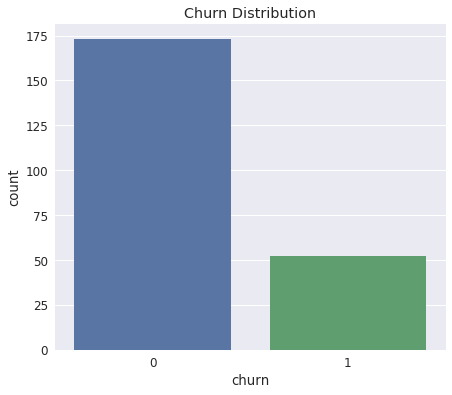

In [42]:
# Churn distribution
sns.set(font_scale=1.2)
plt.figure(figsize=(7, 6))
sns.countplot(x='churn', data=user_pd)
plt.savefig('dist_churn.png')
plt.title('Churn Distribution');
plt.show();

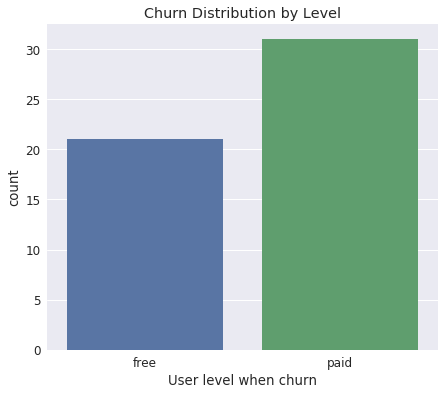

In [43]:
# Churn distribution by level
level_pd = df.filter('page == "Cancellation Confirmation"').groupby('level').count().toPandas()

sns.set(font_scale=1.2)
plt.figure(figsize=(7, 6))
ax = sns.barplot(data=level_pd, x='level', y='count')
plt.xlabel('User level when churn')
plt.title('Churn Distribution by Level');

plt.savefig('churn_dist_by_level.png')

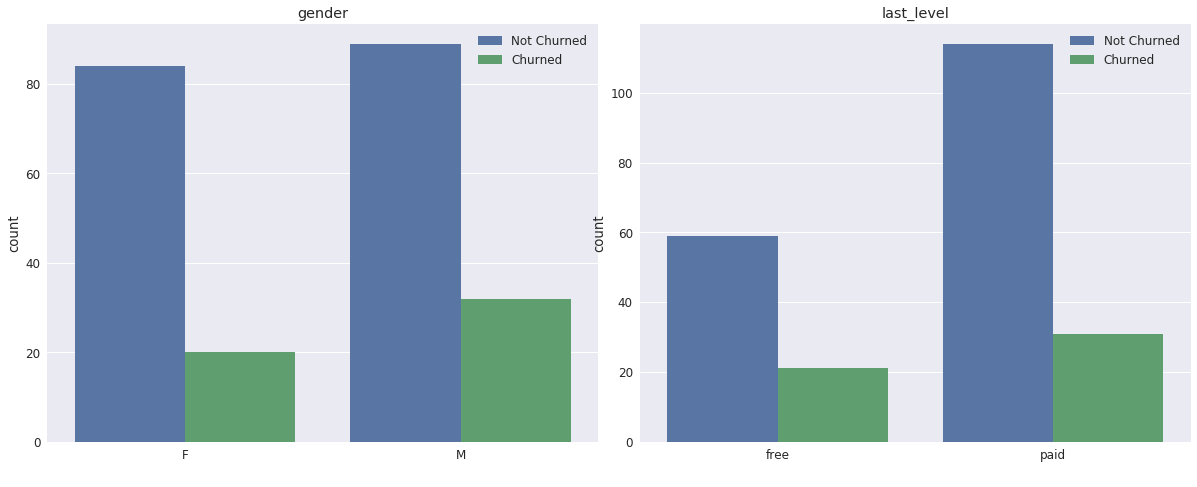

In [44]:
# distribution plots for observations by categorical features
categorical_cols = user_pd.select_dtypes('object').columns.tolist()
categorical_cols.remove('userId')

plt.figure(figsize=(17,7))

for i in range(len(categorical_cols)):
    plt.subplot(1,2,i+1)
    plt.tight_layout()
    sns.countplot(x=categorical_cols[i], data=user_pd, hue='churn')
    plt.legend(['Not Churned','Churned'])
    plt.title(categorical_cols[i])
    plt.xlabel(' ')


plt.savefig('dist_categorical.png')
plt.show();

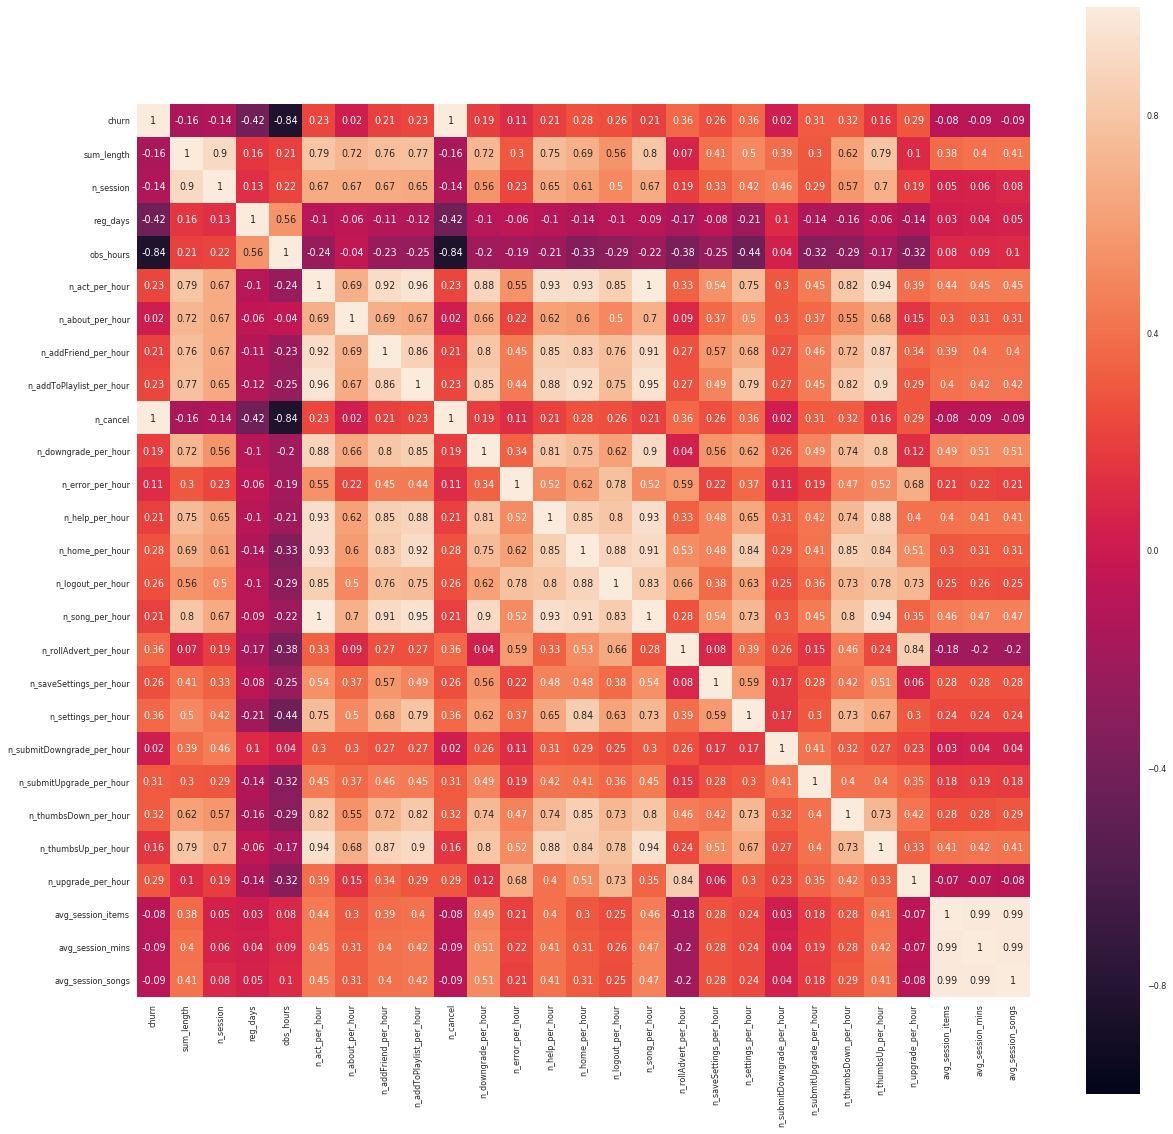

In [108]:
# Numerical Features Correlation Plot

# a funciton to plot correlations among columns
def plot_corr(cols, figsize=(10,10), filename=None, df=user_pd):
    plt.figure(figsize=figsize)
    sns.heatmap(round(df[cols].corr(), 2),
                square=True, annot=True,
                vmin=-1, vmax=1)
    plt.ylim(len(cols), 0)
    sns.set(font_scale=0.7)
    if filename:
        plt.savefig(filename)
    plt.show();

# correlation plot
numerical_cols = user_pd.select_dtypes(include=np.number).columns.tolist()
plot_corr(numerical_cols, figsize=(20, 20), filename='corr_full.png')

Highly correlated (>0.8) variable pairs(groups):

- churn, obs_hours, n_cancel
- sum_length, n_session
- n_act_per_hour, n_addFriend_per_hour, n_addToPlaylist_per_hour, n_downgrade_per_hour, 
  n_help_per_hour, n_home_per_hour, n_song_per_hour, n_thumbsUp_per_hour
- avg_session_items, avg_session_mins, avg_session_songs

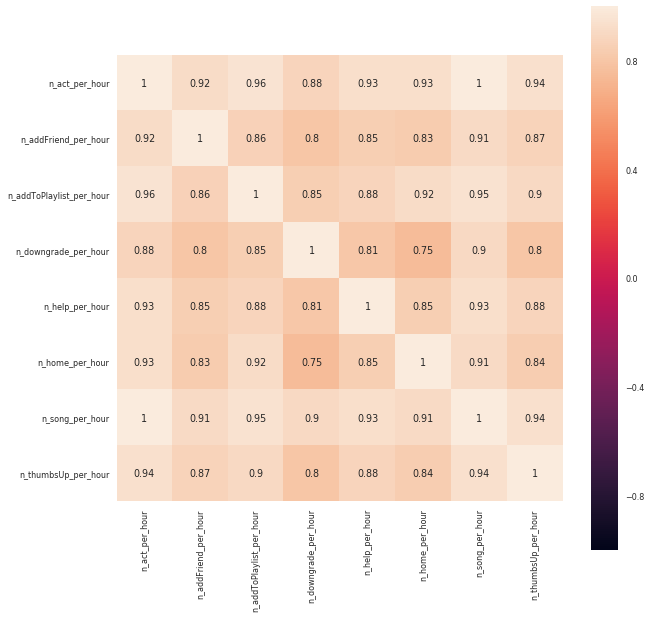

In [46]:
cols = ['n_act_per_hour', 'n_addFriend_per_hour', 'n_addToPlaylist_per_hour', 'n_downgrade_per_hour',
        'n_help_per_hour', 'n_home_per_hour', 'n_song_per_hour', 'n_thumbsUp_per_hour']
plot_corr(cols, filename='corr_n_event_per_hour.png')

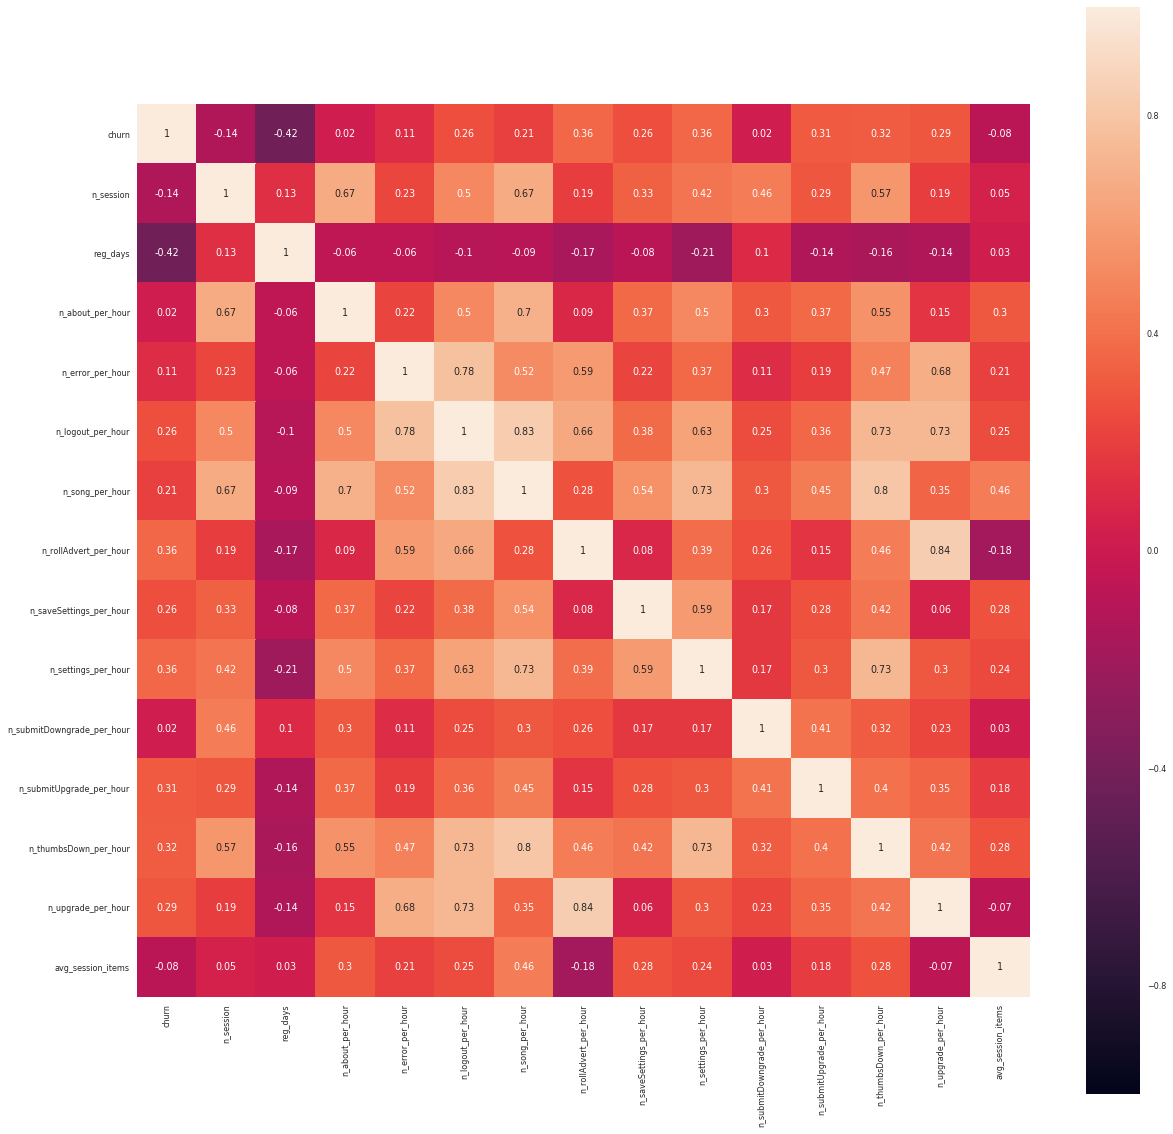

In [47]:
# correlations between numerical features after removing highly correlated columns
drop_cols = ['obs_hours', 'n_cancel', 'sum_length', 'n_act_per_hour', 'n_addFriend_per_hour',
             'n_addToPlaylist_per_hour', 'n_downgrade_per_hour', 'n_help_per_hour',
             'n_home_per_hour', 'n_thumbsUp_per_hour', 'avg_session_mins' , 'avg_session_songs']
numerical_cols = [col for col in numerical_cols if col not in drop_cols]
plot_corr(numerical_cols, figsize=(20,20), filename='corr_numerical.png')

In [48]:
numerical_cols.remove('churn')

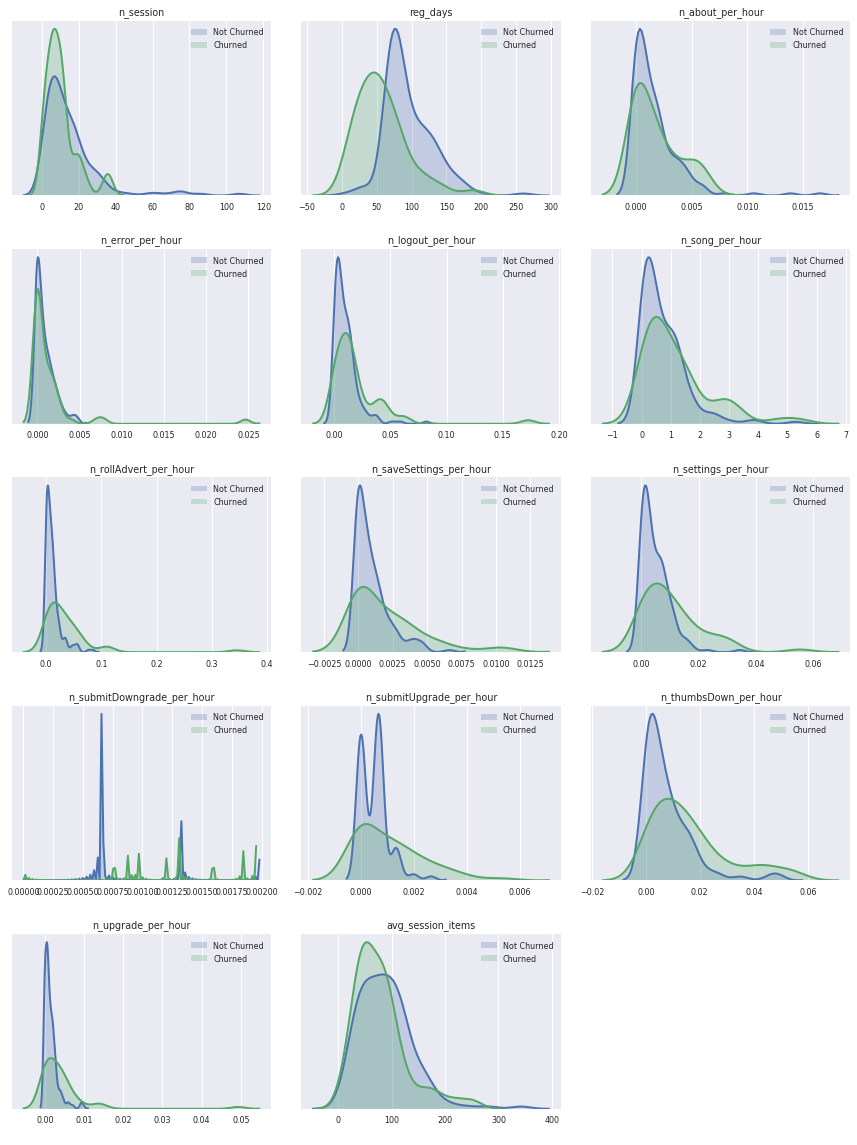

In [49]:
# Distributions of Numerical Features
plt.figure(figsize=(12,16))

for i in range(len(numerical_cols)):
    plt.subplot(5,3,i+1)
    plt.tight_layout()
    sns.distplot(user_pd[user_pd['churn']==0][numerical_cols[i]],
                 hist=False, norm_hist=True, kde_kws={'shade': True, 'linewidth': 2})
    sns.distplot(user_pd[user_pd['churn']==1][numerical_cols[i]],
                 hist=False, norm_hist =True, kde_kws={'shade': True, 'linewidth': 2})
    plt.legend(['Not Churned','Churned'])
    plt.title(numerical_cols[i])
    plt.xlabel(' ')
    plt.yticks([])

plt.savefig('dist_numerical.png')
plt.show();

# Feature Engineering

In [50]:
features = [col for col in user_df.columns if col not in drop_cols]
user_df = user_df.select(*features).withColumnRenamed('churn', 'label')
user_df.persist();
user_df.printSchema()

root
 |-- userId: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- last_level: string (nullable = true)
 |-- n_session: long (nullable = false)
 |-- reg_days: integer (nullable = true)
 |-- n_about_per_hour: double (nullable = true)
 |-- n_error_per_hour: double (nullable = true)
 |-- n_logout_per_hour: double (nullable = true)
 |-- n_song_per_hour: double (nullable = true)
 |-- n_rollAdvert_per_hour: double (nullable = true)
 |-- n_saveSettings_per_hour: double (nullable = true)
 |-- n_settings_per_hour: double (nullable = true)
 |-- n_submitDowngrade_per_hour: double (nullable = true)
 |-- n_submitUpgrade_per_hour: double (nullable = true)
 |-- n_thumbsDown_per_hour: double (nullable = true)
 |-- n_upgrade_per_hour: double (nullable = true)
 |-- avg_session_items: double (nullable = true)



In [51]:
user_df.limit(5).toPandas()

,userId,label,gender,last_level,n_session,reg_days,n_about_per_hour,n_error_per_hour,n_logout_per_hour,n_song_per_hour,n_rollAdvert_per_hour,n_saveSettings_per_hour,n_settings_per_hour,n_submitDowngrade_per_hour,n_submitUpgrade_per_hour,n_thumbsDown_per_hour,n_upgrade_per_hour,avg_session_items
0,100010,0,F,free,7,67,0.000661,0.000000,0.003304,0.181739,0.034365,0.000000,0.000000,0.0,0.000000,0.003304,0.001322,54.428571
1,200002,0,M,paid,6,88,0.001983,0.000000,0.003304,0.255757,0.004626,0.000000,0.001983,0.0,0.000661,0.003965,0.001322,80.000000
2,125,1,M,free,1,72,0.000000,0.000000,0.000000,0.029789,0.003724,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,10.000000
3,124,0,F,paid,29,134,0.004626,0.003965,0.038991,2.695692,0.002643,0.003965,0.013217,0.0,0.000000,0.027096,0.000000,170.137931
4,51,1,M,paid,10,20,0.005107,0.002553,0.061283,5.390342,0.000000,0.002553,0.030641,0.0,0.000000,0.053623,0.000000,251.900000


In [52]:
categorical_cols

['gender', 'last_level']

In [53]:
numerical_cols

['n_session',
 'reg_days',
 'n_about_per_hour',
 'n_error_per_hour',
 'n_logout_per_hour',
 'n_song_per_hour',
 'n_rollAdvert_per_hour',
 'n_saveSettings_per_hour',
 'n_settings_per_hour',
 'n_submitDowngrade_per_hour',
 'n_submitUpgrade_per_hour',
 'n_thumbsDown_per_hour',
 'n_upgrade_per_hour',
 'avg_session_items']

In [54]:
# build data-process stages to encode, scale and assemble features
stages = []

# encode categorical features
for col in categorical_cols:
    indexer = FT.StringIndexer(inputCol=col, outputCol=col+'_idx')
    encoder = FT.OneHotEncoderEstimator(inputCols=[indexer.getOutputCol()], outputCols=[col+'_vec'])
    stages += [indexer, encoder]

# scale numeric features
for col in numerical_cols: 
    assembler = FT.VectorAssembler(inputCols=[col], outputCol=col+'_vec')
    scaler = FT.StandardScaler(inputCol=col+'_vec', outputCol=col+'_scl')
    stages += [assembler, scaler]

# assemble features
input_cols = [c+'_vec' for c in categorical_cols] + [c+'_scl' for c in numerical_cols]
assembler = FT.VectorAssembler(inputCols=input_cols, outputCol='features')
stages += [assembler]

# Modeling
For the modeling part we will perform the following steps:
 - Split the full dataset into train, test, and validation sets.
 - Test out several of the machine learning methods.
 - Evaluate the accuracy of the various models and come up with the best.
 - Determine your winning model based on test accuracy.
 - Fine-tune the parameters of the best model from the above step.
 - Report results of the best and tuned model on the validation set.
 
 Since the churned users are a fairly small subset, we will use the F1 score as the metric to optimize.

#### Train-Test Split

From the churn distribution, we know that this is an unbalanced dataset.<br>
To avoid unbalanced results in random split, we first make a train set with sampling by label, then subtract them from the whole dataset to get the test set.

In [55]:
# prepare training and test data, sample by label
ratio = 0.7
train = user_df.sampleBy('label', fractions={0:ratio, 1:ratio}, seed=42)
test = user_df.subtract(train)

In [56]:
print('train set:')
train.groupBy('label').count().show()
print('test set:')
test.groupBy('label').count().show()

train set:
+-----+-----+
|label|count|
+-----+-----+
|    1|   36|
|    0|  127|
+-----+-----+

test set:
+-----+-----+
|label|count|
+-----+-----+
|    1|   16|
|    0|   46|
+-----+-----+



#### Baseline Model

We evaluate two baseline models, one with all users labelled as churn = 1, one with all users labelled as churn = 0. And we calculated the model accuracy and f1 score.

In [57]:
results_base_all_1 = test.withColumn('prediction', F.lit(1.0))
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_base_all_1, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_base_all_1, {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.25806451612903225
F-1 Score:0.10587262200165426


In [58]:
results_base_all_0 = test.withColumn('prediction', F.lit(0.0))
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set metrics:')
print('Accuracy: {}'.format(evaluator.evaluate(results_base_all_0, {evaluator.metricName: "accuracy"})))
print('F-1 Score:{}'.format(evaluator.evaluate(results_base_all_0, {evaluator.metricName: "f1"})))

Test set metrics:
Accuracy: 0.7419354838709677
F-1 Score:0.6320191158900836


As we can see, the baseline model of labelling all users with `churn = 0` actually does a descent job on test set, with accuracy of 74.19% and f1 score of 0.6320.

#### Machine Learning Models to evaluate

In order to select the best model for the final tuning, we will apply several ML models from in Spark's MLlib and compare their accuracy metrics.

Because the evaluators provided by Spark don’t fit our usage very well, we make a custom evaluate method to peek at the scores when testing prototypes.

In [59]:
def fit_predict(pipeline):
    # fit on train set
    start = time.time()
    model = pipeline.fit(train)
    end = time.time()
    print(f'train time: {end-start:.0f}s')

    # predict on test set
    pred_train = model.transform(train)
    pred_test = model.transform(test)

    return model, pred_train, pred_test

In [60]:
def evaluate(pred, beta=1):
    # true positive
    tp = pred.filter((pred.prediction==1)&(pred.label==1)).count()
    # false positive
    fp = pred.filter((pred.prediction==1)&(pred.label==0)).count()
    # false negative
    fn = pred.filter((pred.prediction==0)&(pred.label==1)).count()
    # true negative
    tn = pred.filter((pred.prediction==0)&(pred.label==0)).count()

    # calculate scores
    accuracy = (tp+tn)/(tn+fp+fn+tp)
    precision = tp/(tp+fp) if (tp+fp)!=0 else 0
    recall = tp/(tp+fn) if (tp+fn)!=0 else 0
    f_beta = (1+beta**2)*(precision*recall)/(beta**2*precision+recall) if (precision+recall)!=0 else 0

    print(f'f{beta}-score:{f_beta:.2f}', )
    print(f'precision:{precision:.2f}')
    print(f'recall:{recall:.2f}')
    print(f'accuracy:{accuracy:.2f}')
    print('confusion matrix:')
    print(f'TP:{tp:.1f}\t | FP:{fp:.1f}')
    print(f'FN:{fn:.1f}\t | TN:{tn:.1f}')

In [97]:
# try different models with default params
lr = LogisticRegression(maxIter=10)
dtc = DecisionTreeClassifier(seed=42)
rfc = RandomForestClassifier(seed=42)
gbt = GBTClassifier(maxIter=10, seed=42)

pipelines = [
    Pipeline(stages=stages+[lr]),
    Pipeline(stages=stages+[dtc]),
    Pipeline(stages=stages+[rfc]),
    Pipeline(stages=stages+[gbt])
]

for model, pipeline in zip([lr, dtc, rfc, gbt], pipelines):
    print('\n', type(model))
    model, pred_train, pred_test = fit_predict(pipeline)
    print('{:-^30}'.format('pred_train'))
    evaluate(pred_train)
    print('{:-^30}'.format('pred_test'))
    evaluate(pred_test)


 <class 'pyspark.ml.classification.LogisticRegression'>
train time: 76s
----------pred_train----------
f1-score:0.89
precision:0.91
recall:0.86
accuracy:0.95
confusion matrix:
TP:31.0	 | FP:3.0
FN:5.0	 | TN:124.0
----------pred_test-----------
f1-score:0.80
precision:0.86
recall:0.75
accuracy:0.90
confusion matrix:
TP:12.0	 | FP:2.0
FN:4.0	 | TN:44.0

 <class 'pyspark.ml.classification.DecisionTreeClassifier'>
train time: 62s
----------pred_train----------
f1-score:0.97
precision:1.00
recall:0.94
accuracy:0.99
confusion matrix:
TP:34.0	 | FP:0.0
FN:2.0	 | TN:127.0
----------pred_test-----------
f1-score:0.67
precision:0.71
recall:0.62
accuracy:0.84
confusion matrix:
TP:10.0	 | FP:4.0
FN:6.0	 | TN:42.0

 <class 'pyspark.ml.classification.RandomForestClassifier'>
train time: 77s
----------pred_train----------
f1-score:0.96
precision:1.00
recall:0.92
accuracy:0.98
confusion matrix:
TP:33.0	 | FP:0.0
FN:3.0	 | TN:127.0
----------pred_test-----------
f1-score:0.77
precision:1.00
recall:0.6

Based on the F1-scores from the test set, we decide to use `LogisticRegression` for final tuning.

In [112]:
lr = LogisticRegression()
print(lr.explainParams())

pipeline = Pipeline(stages=stages+[lr])
param_grid = (ParamGridBuilder().addGrid(lr.maxIter, [10, 50, 100])
                                .build())
# evaluator = BinaryClassificationEvaluator()
# evaluator = FbetaScore(beta=1)

f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid,
                    evaluator=f1_evaluator, numFolds=3)

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must beequal wi

In [113]:
# fit, predict and evaluate
cv_model, pred_train, pred_test = fit_predict(cv)
print('{:-^30}'.format('pred_train'))
evaluate(pred_train)
print('{:-^30}'.format('pred_test'))
evaluate(pred_test)

train time: 2175s
----------pred_train----------
f1-score:0.89
precision:0.91
recall:0.86
accuracy:0.95
confusion matrix:
TP:31.0	 | FP:3.0
FN:5.0	 | TN:124.0
----------pred_test-----------
f1-score:0.80
precision:0.86
recall:0.75
accuracy:0.90
confusion matrix:
TP:12.0	 | FP:2.0
FN:4.0	 | TN:44.0


In [114]:
# save best model
cv_model.bestModel.save('./lr_model')

In [76]:
# load model if needed
# best_model_lr = PipelineModel.load("lr_model")

#### Best Model Parameters

In [79]:
print('Best Param (regParam): ', cv_model.bestModel.stages[-1]._java_obj.getRegParam())
print('Best Param (MaxIter): ', cv_model.bestModel.stages[-1]._java_obj.getMaxIter())
print('Best Param (elasticNetParam): ', cv_model.bestModel.stages[-1]._java_obj.getElasticNetParam())

Best Param (regParam):  0.0
Best Param (MaxIter):  10
Best Param (elasticNetParam):  0.0


#### Best Model Coefficients

In [80]:
print("Best Model Coefficients: ", str(cv_model.bestModel.stages[-1].coefficients))

Best Model Coefficients:  [-0.0189464213011,0.385013724133,-7.70719076207,-0.220070271503,-1.47200822162,-1.46364652418,2.09059030549,3.50123341689,5.2298900757,1.72529625551,-0.0462571976093,-2.40208531446,2.8845981458,3.23335647918,-1.1779242752,-3.23127581732]


In [84]:
feat_imp = cv_model.bestModel.stages[-1].coefficients.toArray()
feat_imp_pd = pd.DataFrame({'feature':categorical_cols+numerical_cols, 'importance':feat_imp})
feat_imp_pd = feat_imp_pd.sort_values(by=['importance'], ascending=False)
feat_imp_pd

,feature,importance
8,n_rollAdvert_per_hour,5.229890
7,n_song_per_hour,3.501233
13,n_thumbsDown_per_hour,3.233356
12,n_submitUpgrade_per_hour,2.884598
6,n_logout_per_hour,2.090590
9,n_saveSettings_per_hour,1.725296
1,last_level,0.385014
0,gender,-0.018946
10,n_settings_per_hour,-0.046257
3,reg_days,-0.220070


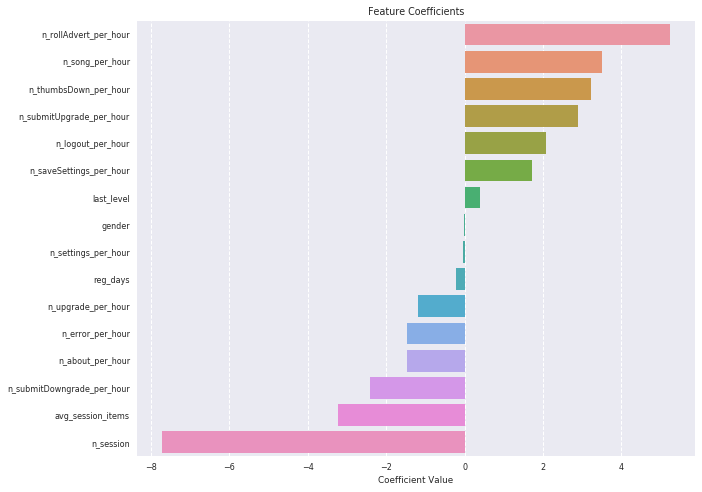

In [90]:
plt.figure(figsize=(10,8))
sns.barplot(data=feat_imp_pd, y='feature', x='importance', zorder=2);
plt.grid(axis='x', linestyle='--', zorder=0)
plt.title('Feature Coefficients')
plt.ylabel('')
plt.xlabel('Coefficient Value')
plt.savefig('feat_imp.png')
plt.show();

# Conclusion

### Summary
In this notebook, we implemented a model to predict customer churn. We removed rows with no userId, converted timestamp to a human readable format. We selected 4 models: Logistic Regression, GBM, Decision Tree, and Random Forest to compare and select Logistic Regression as the final model. We used cross validation and grid search to fine tune the final model. We achieved 90% accuracy, and 0.80 F1 score on the test set, which is about 27% improvement compared to our baseline model - sending everyone an offer.

### Improvements
 - We could spend more time on feature engineering, consider more factors, adding more domain knowledges and expertise.
 - Explore more parameters in model tuning session (GridSearch).